# Практикум по стохастическому анализу. Часть №2

Выполнил \
Пилюшенок Артур \
студент 415 группы ВМК МГУ

In [1]:
import numpy as np                              # matrix calculations
from matplotlib import pyplot as plt            # plotting
from time import time                           # calculation time
from tqdm import tqdm                           # progress bar
import sympy as sym                             # symbolic calculations
from itertools import product                   # for Dirichlet

from scipy.stats import chi2, pareto, norm
from scipy.optimize import minimize, rosen, NonlinearConstraint

In [2]:
def rand_bern(p, *args):
    '''
    Bernoulli scheme generator
    returns tensor with given shapes
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if p > 1 or p < 0:
        raise ValueError("Probability of success must be in range [0,1].")
    if not args:
        return int(np.random.rand() <= p)
    return (np.random.rand(*args) <= p).astype(int)

In [3]:
def rand_expo(l, *args):
    '''
    Exponential distribution generator
    returns tensor with given shapes
    l - parameter, must be positive
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if not l > 0:
        raise ValueError('Parameter of exponential distribution must be a positive float number.')
    return -np.log(np.random.rand(*args)) / l

In [4]:
def rand_poisson_expo(l):
    '''
    Poisson distribution generator, derivative of rand_expo
    returns realization of one random value
    l - parameter, must be positive
    error handling in rand_expo
    '''
    Y = 0
    summ = 0
    while True:
        summ += rand_expo(l)
        if summ > 1:
            return Y
        else:
            Y += 1

def rand_poisson_expo_vec(l, *args):
    '''
    Poisson distribution generator, derivative of rand_expo
    returns tensor with given shapes
    l - parameter, must be positive
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_expo
    '''
    if not args:
        return rand_poisson_expo(l)
    else:
        Y = np.zeros(*args)
        summ = np.zeros(*args)
    while True:
        X = rand_expo(l, *args)
        summ = summ + X
        Y[summ < 1] = Y[summ < 1] + 1
        if not np.any(Y[summ < 1]):
            return Y

In [5]:
def rand_norm(loc, scale, *args):
    '''
    Standard normal distribution generator, derivative of rand_expo
    returns tensor with given shapes
    shapes error handling in rand_expo
    '''
    omega = rand_expo(0.5, *args)
    alpha = 2 * np.pi * np.random.rand(*args)
    return loc + scale * np.sqrt(omega) * np.cos(alpha)

def rand_norm_pair(*args):
    '''
    Standard normal distribution generator, derivative of rand_expo
    returns pair of tensors with given shapes
    shapes error handling in rand_expo
    '''
    omega = rand_expo(0.5, *args)
    alpha = 2 * np.pi * np.random.rand(*args)
    return np.array((np.sqrt(omega) * np.cos(alpha), np.sqrt(omega) * np.sin(alpha)))

In [6]:
def rand_Cauchy(loc=0.0, scale=1.0, *args):
    '''
    Cauchy distribution generator
    returns tensor with given shapes
    loc - shift parameter
    scale - scale parameter, must be positive
    shapes error handling in rand_expo
    '''
    if not scale > 0:
        raise ValueError('Scale must be a positive float number.')
    return loc + scale * np.tan(np.pi * (np.random.rand(*args) - 0.5))

## Задание 7

### Условие
1. Методом случайного поиска найти минимальное значение функции $f$ на множестве $A = \{(x_1,x_2):~x_1^2+x_2^2\leqslant 1\}$, где
$$
f(x_1,x_2) = x_1^3\sin\frac{1}{x_1} + 10x_1x_2^4\cos\frac{1}{x_2},\quad x_1,x_2\neq0.
$$
При $x_1=0$ или $x_2=0$ функция доопределяется по непрерывности.

2. Методом имитации отжига найти минимальное значение функции Розенброка $g$ в пространстве $\mathbb{R}^2$, где
$$
g(x) = (x_1-1)^2 + 100(x_2-x_1^2)^2.
$$

3. Оценить точность и сравнить результаты со стандартными методами оптимизации.

### Метод случайного поиска

Метод случайного поиска минимального значения функции $f(x)$ на множестве $A$:
1. Смоделировать выборку размера $n$ точек $x\sim\mathrm{U}\{A\}$ (равномерно распределены на множестве A)
2. Выбрать ту реализацию случайной величины, на которой достигается наименьшее значение.

По условию задачи множество $A$ - круг единичного радиуса на плоскости $(x_1,x_2)$. Пусть $x=(x_1,x_2)\sim\mathrm{U}(A)$. По определению для любого борелевского множества $M$ выполняется ($\mu$ - мера Лебега на плоскости)
$$
\mathbb{P}\left( (x_1,x_2)\in M \right) = \dfrac{\mu (M)}{\mu (A)} = \dfrac{1}{\pi}\iint\limits_M dt_1dt_2 = \begin{vmatrix}
t_1 = r\cos\alpha \
t_2 = r\sin\alpha
\end{vmatrix} = \dfrac{1}{\pi}\iint\limits_M rdrd\alpha = \iint\limits_M d(r^2)d\left(\frac{\alpha}{2\pi}\right).
$$

Следовательно, будем моделировать
$$
\begin{cases}
x_1 = \sqrt{\omega}\cos\alpha \\
x_2 = \sqrt{\omega}\sin\alpha
\end{cases}
$$
где $\omega\sim\mathrm{U}[0,1], \alpha\sim\mathrm{U}[0,2\pi]$.


Данная функция $f(x)=x_1^3\sin\frac{1}{x_1}+10x_1x_2^4\cos\frac{1}{x_2}$ обладает свойствами 
1. $f(x_1,-x_2)=f(x_1,x_2)$ (чётность по $x_2$)
2. $f(-x_1,0)=f(x_1,0)=x_1^3\sin\frac{1}{x_1}$
3. $f(0,0)=0$

Следовательно, если $x^*=(x_1^*,x_2^*)$ доставляет минимум функции, то $(x_1^*,-x_2^*)$ также доставляет минимум. \
Минимум меньше нуля, ведь $f(0.1, 0.1) < 0$ (проверяется численно). \
Следовательно, функция $f$ имеет хотя бы две точки глобального минимума.

Отметим, что при реализации метода случайного поиска значения $x_1=0, x_2=0$ достигаются с нулевой вероятностью. Следовательно, при вычислении значения заданной функции в точках выборки можно не обрабатывать неопределенность.

<!-- Пусть $\varepsilon>0$ - наперед заданная точность вычислений.  -->
Пусть $x^*=(x_1^*,x_2^*)$ доставляет минимум функции $f(x_1,x_2)$. \
Оценим точность работы алгоритма при помощи многомерной теоремы Лагранжа
$$
|f(x) - f(x^*)| \leqslant \max\limits_A 
\sqrt{\left(\dfrac{\partial f}{\partial x_1}\right)^2 + \left(\dfrac{\partial f}{\partial x_2}\right)^2} \cdot || x - x^* ||.
$$

Справедливы следующие оценки
$$
\begin{aligned}
\left|\dfrac{\partial f}{\partial x_1}\right| &= \left| 3x_1^2\sin\frac{1}{x_1} - x_1\cos\frac{1}{x_1} + 10x_2^4\cos\frac{1}{x_2}  \right| \leqslant 14. \\
\left|\dfrac{\partial f}{\partial x_2}\right| &= \left| 40x_1x_2^3\cos\frac{1}{x_2} + 10x_1x_2^2\sin\frac{1}{x_2} \right| \leqslant 50.
\end{aligned}
$$

Далее выберем окрестность радиуса $\delta\in(0,1)$: $B_\delta(x^*)=\{ x: ||x-x^*||\leqslant \delta \}$. \
Пусть $p$ - вероятность того, что в $B_\delta(x^*) \cap A$ находится хотя бы одна точка выборки $(x_1,x_2,\dots,x_n)$.
$$
p = \mathbb{P}(\exists k:~||x_k-x||\leqslant\delta) = 1 - \mathbb{P}(\forall k~ ||x_k-x^*||>\delta) = 1 - \prod_{k=1}^n\mathbb{P}(||x_k-x^*||>\delta).
$$

Если $B_\delta(x^*) \cap A = B_\delta(x^*)$, вероятность в правой части полученного выражения можно вычислить как отношение соответствующих площадей:
$$
\mathbb{P}(||x_k-x^*||>\delta) = \dfrac{\pi - \pi\delta^2}{\pi} = 1 - \delta^2 < 1 - \frac{\delta^2}{2}.
$$
Если $B_\delta(x^*) \cap A \neq B_\delta(x^*)$, то ограничим вероятность сверху числом $1-\frac{\delta^2}{2}$. Этот случай включает в себя возможное расположение точки $x^*$ на границе единичного круга. Ясно, что в худшем случае половина окрестности не будет лежать в круге.

Таким образом
$$
1-p = \prod_{k=1}^n\mathbb{P}(||x_k-x^*||>\delta) < \left(1-\frac{\delta^2}{2}\right)^n.
$$
Зафиксируем $p, \delta$. Тогда с вероятностью $p$ в окрестности радиуса $\delta$ искомого решения будет находиться элемент выборки, если размер выборки составляет
$$
n = \bigg\lfloor\dfrac{\ln(1-p)}{\ln\left(1-\frac{\delta^2}{2}\right)}\bigg\rfloor.
$$

Если выбрать $x\in B_\delta(x^*)$ погрешность вычисления составит
$$
|f(x) - f(x^*)| \leqslant \sqrt{14^2 + 50^2}\cdot\delta = \varepsilon.
$$
Таким образом, по заданным $\varepsilon$ - погрешности вычисления и $p$ - уровне доверия, можно вычислить $\delta, n$.

In [7]:
def func(x1, x2):
    return x1 ** 3 * np.sin(1 / x1) + 10 * x1 * x2 ** 4 * np.cos(1 / x2)

def min_random_search(func, eps, p):
    """
    Calculate minimum of 
        f(x_1,x_2) = x_1^3\sin\frac{1}{x_1} + 10x_1x_2^4\cos\frac{1}{x_2}
    on unit cirlce.
    """
    delta = eps / np.sqrt(2696)
    n_points = np.floor(np.log(1 - p) / np.log(1 - delta**2 / 2)).astype(int)
    omega_sample = np.random.rand(n_points)
    alpha_sample = np.random.rand(n_points) * 2 * np.pi
    x1 = np.sqrt(omega_sample) * np.cos(alpha_sample)
    x2 = np.sqrt(omega_sample) * np.sin(alpha_sample)
    f_min = np.min(func(x1, x2))
    i_min = np.argmin(func(x1, x2))
    return f_min, [x1[i_min], x2[i_min]], n_points


print(f"f(0.1,0.1) = {func(0.1,0.1):.4f} < 0.")

eps = 0.05
p = 0.99
val, point, n_points = min_random_search(func, eps, p)
print(f"f*({point[0]:.8f},{point[1]:.8f})= {val:.8f} obtained by sample of {n_points} points.")

f(0.1,0.1) = -0.0006 < 0.
f*(-0.35547645,0.93467442)= -1.28835256 obtained by sample of 9932428 points.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


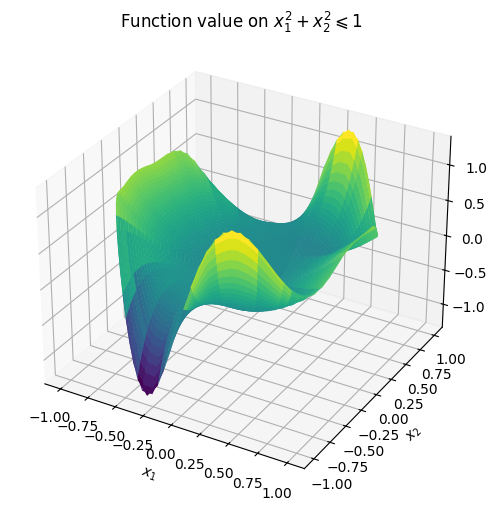

In [8]:
n_points = 100
r = np.linspace(0.001, 1, n_points)
alpha = np.linspace(-2*np.pi, 2*np.pi, n_points)
r, alpha = np.meshgrid(r, alpha)

X = r * np.sin(alpha)
Y = r * np.cos(alpha)
Z = func(X, Y)

plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title('Function value on $x_1^2+x_2^2\leqslant1$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.savefig('./images/min-random-search.eps', format='eps')

### Метод имитации отжига

Метод имитации отжига (simulated annealing):
1. Выбирается произвольное начальное состояние $s_0$ и достаточно большая температура $T$.
2. Выбирается сосед для текущего состояния.
3. Осуществляется переход в соседнее состояние с некоторой функцией вероятности, зависящей от разницы значений функции в соседнем и текущих положениях и текущей температуры.
4. Температура снижается по некоторому закону охлаждения.
5. Повторяем шаги 2-4, пока не температура не станет достаточно близкой к нулю, либо не закончится число итераций.

В методе simulated annealing выберем следующие функции:
- функция выбора соседа - нормальная случайная величина со средним $s_i=(x_i,y_i)$ и дисперсией $\sigma^2 T_i$
- функция вероятности перехода - $e^{-\Delta F_i/T_i}$
- функция понижения температуры - $T_{i+1}=kT_i,~ k\in(0,1)$

Аналитически минимум функции Розенброка достигается в точке $x=(1,1)$ и равен нулю. \
Постараемся воспроизвести этот результат численно.

In [9]:
def func_Rosenbrock(x):
    return (x[0] - 1)**2 + 100 * (x[1] - x[0]**2)**2

def choose_neighbour(s_i, T_i, sigma):
    pair = rand_norm_pair()
    return s_i + np.sqrt(T_i) * sigma * pair

def transfer_probability(d_F_i, T_i):
    return np.exp(-d_F_i / T_i)

def reduce_temperature(T_i, k):
    return k * T_i

def simulated_annealing(func, k, sigma, eps, s_0, T_0):
    """
    Simulated annealing minimization method for given function.
    """
    start = time()
    iters = 0
    T = T_0
    s = s_0
    f_s = func(s)
    while T > eps:
        iters += 1
        s_neig = choose_neighbour(s, T, sigma)
        f_neig = func(s_neig)
        delta = f_neig - f_s
        if delta > 0:
            p = transfer_probability(delta, T)
            if np.random.rand() < p:
                s = s_neig
                f_s = f_neig
        else:
            s = s_neig
            f_s = f_neig
        T = reduce_temperature(T, k)
    return s[0], s[1], func(s), time() - start

In [10]:
sigma = 3
k = 0.999
eps = 1e-6
T_0 = 10

n_tests = 1000
data_tests = np.zeros(shape=(n_tests, 4))
for i in tqdm(range(n_tests)):
    s_0 = 10 * rand_norm_pair()
    data_tests[i, :] = simulated_annealing(func_Rosenbrock, k, sigma, eps, s_0, T_0)

100%|██████████| 1000/1000 [04:00<00:00,  4.16it/s]


In [11]:
ind_min = data_tests[:, 2].argmin()
print(f"g*({data_tests[ind_min, 0]:.8f}, {data_tests[ind_min, 1]:.8f}) = {data_tests[ind_min, 2]:.12f}")
print(f"median calculation time {np.median(data_tests[:, 3]):.2f} s")

g*(0.99998812, 0.99997569) = 0.000000000172
median calculation time 0.24 s


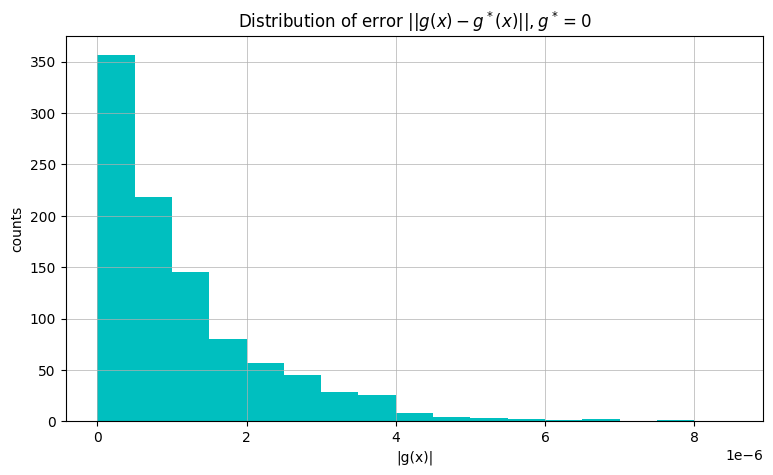

In [12]:
bins = np.arange(0, 9 * 1e-6, 5 * 1e-7)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

plt.hist(data_tests[:, 2], bins=bins, color='c')

plt.title('Distribution of error $||g(x)-g^*(x)||, g^*=0$')
plt.ylabel('counts')
plt.xlabel('|g(x)|')

plt.savefig('./images/rosenbrock-error.eps', format='eps')

### Сравнение с методами минимизации

Функция, минимум которой был найден методом случайного поиска не обладает непрерывными производными, следовательно, градиентные методы навряд ли дадут правильный результат. Сравним наш метод с методом Constrained Optimization By Linear Optimization (COBYLA).

In [13]:
def func_1(x):
    return x[0] ** 3 * np.sin(1 / x[0]) + 10 * x[0] * x[1] ** 4 * np.cos(1 / x[1])

In [14]:
x0 = [-0.5, 0.7]
limits = NonlinearConstraint(lambda x: (x**2).sum(), 0, 1)
res = minimize(func_1, x0, method='COBYLA', constraints=limits)
res.fun, res.x

(np.float64(-1.2884892067125973), array([-0.35744317,  0.9339349 ]))

Функция Розенброка является встроенной в пакет $\texttt{scipy}$, как и метод безусловной минимизации Nelder-Mead Simplex.

In [15]:
x0 = [15, 0.15]
res = minimize(rosen, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
res.fun, res.x

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 130
         Function evaluations: 248


(np.float64(1.713594997627334e-17), array([1.        , 1.00000001]))

## Задание 8

### Условие
1. Применить метод Монте-Карло к решению первой краевой задачи для двумерного уравнения Лапласа в единичном круге
$$
\begin{cases}
\Delta u = 0,(x,y)\in D \
u\vert_{\delta D} = f(x,y) \\
u\in C^2(D), f\in C(\delta D) \\
D=\{(x,y)\in\mathbb{R}^2: x^2+y^2\leqslant 1 \}
\end{cases}
$$

2. Для функции $f(x,y) = x^2-y^2$ найти аналитическое решение и сравнить с полученным по методу Монте-Карло.

### Метод Монте-Карло для уравнения Лапласа

<!-- Будем решать задачу не в единичном круге, а в единичном квадрате. Решение при этом не изменится, ведь ($x^2-y^2$) - единственное решение поставленной задачи в единичном круге, которое является непрерывным. После работы алгоритма выберем только те точки, которые лежат в единичном круге. -->

<!-- Введём сетку на единичном квадрате $|x|\leqslant1, |y|\leqslant1$. -->

Введём равномерную квадратную сетку в единичном круге с шагом $h$. Пусть $P(x_i,y_i)$ - узел, внутренняя точка сетки (имеет 4 соседа), $Q(\tilde{x}_i,\tilde{y}_i)$ - граничная точка сетки. \
Рассмотрим соответствующую теоретико-вероятностную схему. \
Будем искать вероятность $u(P,Q)$, того, что, выйдя из внутренней точки $P$, будет достигнута граничная точка $Q$. \
Считаем, что все соседи выбираются равновероятным образом. Тогда для соседних точек $P_i,i=\overline{1,4}$ по отношению к $P$ справедливо
$$
u(P,Q) = \dfrac{1}{4}\left( u(P_1,Q) + u(P_2, Q) + u(P_3, Q) + u(P_4, Q) \right).
$$

Таким образом, мы пришли к конечноразностному уравнению, которое является конечно-разностной схемой для уравнения Лапласа:
$$
u(P) = \dfrac{1}{4}\left( u(P_1) + u(P_2) + u(P_3) + u(P_4) \right),
$$
где $P$ - внутренняя, $P_i,i=\overline{1,4}$ - соседние по отношению к $P$.

Вероятности $u(P,Q)$ можно вычислять приближенно: будем моделировать $N$ раз "блуждание" из точки $P$ в точку $Q$ и считать число $M(Q)$ испытаний, при которых "блуждание" оканчивается в точке $Q$:
$$
u(P,Q)\approx \frac{M(Q)}{N}.
$$

Чтобы решить поставленную задачу Дирихле, нужно немного обобщить полученную вероятностную схему. Нужно считать, что при выходе из узла $P$ и дальнейшем посещении граничной точки $Q$ с нас взымается штраф, равный $f(Q)$. Ясно, что величина выплаченного штрафа является случайной величиной. Обозначим её $\xi(P)$.

Пусть $\{Q_1,\dots,Q_s\}$ - совокупность всех граничных точек.
Тогда величина штрафа принимает значения $\{f(Q_1),\dots,f(Q_s)\}$, вероятность заплатить $f(Q_l)$ равняется $u(P,Q_l)$.
Значит, математическое ожидание штрафа определяется как:
$$
w(P) = \mathbb{E}\xi(P) = \sum_{l=1}^{s}f(Q_l)u(P,Q_l).
$$
Причем, $w(P)$ удовлетворяет разностному уравнению
$$
w(P) = \dfrac{1}{4}\left( w(P_1) + w(P_2) + w(P_3) + w(P_4) \right).
$$
Это непосредственно проверяется из исходной конечно-разностной схемы для уравения Лапласа при $Q=Q_l$ и суммировании обеих частей уравнений.

Таким образом, $w(P)$ принимает на границе заданные значения, является решением задачи Дирихле.

Дополнительные сведения можно найти в [1], стр. 117.

Заметим, что для вычисления $w(P)$ необязательно нужно вычислять вероятности $u(P,Q_l)$ по отдельности.

Вычисляем $w(P)$ приближённо:
$$
w(P) \approx \sum_{l=1}^s f(Q_l) \frac{M(Q_l)}{N}.
$$
Достаточно $M(Q_l)$ раз прибавить $f(Q_l)$ к итоговой сумме.


Таким образом, справедлив следующий алгоритм:
1. Задать квадратную сетку с числом точек $N=\texttt{n\_points}$ по каждой оси.
2. Получить все внутренние точки (они удовлетворяют условию $x^2+y^2 < 1$).
3. Перебрать все внутренние точки $P$.
4. Смоделировать блуждание $M=\texttt{n\_tests}$ раз: идём до произвольной граничной точки $Q$.
5. Прибавляем значение $f(Q) / M$ к итоговому результату в точке $P$.

In [16]:
def func_bound(x):
    """
    Boundary function for Dirichlet equation.
    """
    return x[0]**2 - x[1]**2

def solve_Laplace(func_bound, n_points, n_tests):
    """
    Monte-Carlo solver for Dirichlet equation with boundary func_bound(\cdot) on unit circle.
    Args:
        n_points - number of points in single axis grid
        n_tests  - number of brownian walks for each inner point
    Returns:
        inner_points - array of 2-d points
        func_grid    - calculated solution values at inner_points
    """

    # get every inner point
    carthesian_grid = np.array(list(product(np.linspace(-1, 1, n_points, endpoint=True), repeat=2)), dtype=np.float64)
    is_in_circle = (carthesian_grid**2).sum(axis=1) < 1
    inner_points = carthesian_grid[is_in_circle]

    # resulting array
    func_grid = np.zeros(inner_points.shape[0])     

    # main body
    step = 1 / (n_points + 1)                                   # grid distance
    for index, point in tqdm(enumerate(inner_points), total=inner_points.shape[0]):
        func_value = 0                                          # expected value is zero at start
        for _ in range(n_tests):
            walk = point                                        # start at chosen point
            while (walk**2).sum() < 1:                          # while walk is in bounds
                choise = 2 * rand_bern(0.5, 2) - 1              # choose a neighbour with 1/4 probability
                walk = walk + step * choise
            func_grid[index] += func_bound(walk) / n_tests      # cumulate expected value
    return inner_points, func_grid

In [17]:
n_points = 20
n_tests = 200

x, val = solve_Laplace(func_bound, n_points, n_tests)

100%|██████████| 276/276 [01:20<00:00,  3.42it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


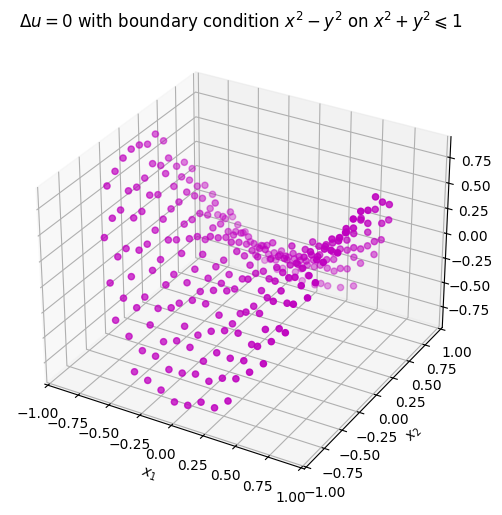

In [18]:
plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.scatter(x[:,0], x[:,1], val, color='m')
ax.set_title('$\Delta u=0$ with boundary condition $x^2-y^2$ on $x^2+y^2\leqslant1$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.savefig('./images/laplace-solution.eps', format='eps')

### Сравнение численного результата с аналитическим решением

Функция $f(x,y)=x^2-y^2$ удовлетворяет $\Delta u=0$. Для внешней задачи Дирихле условием регулярности является ограниченность функции $u$. Функция $f=u$ является ограниченной, следовательно, данное уравнение имеет единственное решение, равное $x^2-y^2$.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


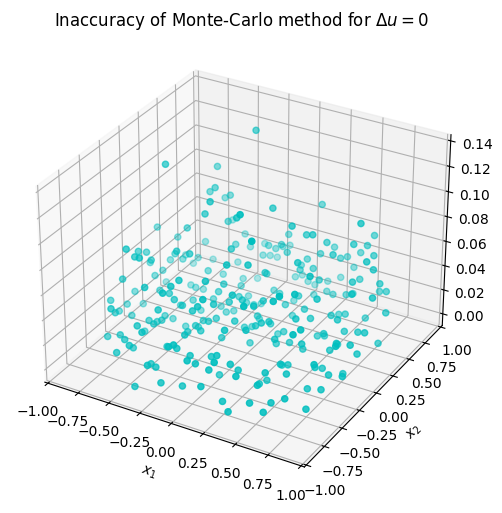

In [19]:
true_val = x[:,0]**2 - x[:,1]**2

plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.scatter(x[:,0], x[:,1], abs(true_val - val), color='c')
ax.set_title('Inaccuracy of Monte-Carlo method for $\Delta u=0$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.savefig('./images/laplace-error.eps', format='eps')

## Задание 9

### Условие

Рассмотреть два вида гауссовских процессов:

- Винеровский процесс $W(t), t\in[0,1], W(0)=0$.

- Процесс Орнштейна-Уленбека $X(t), t\in[0,1], X(0)=X_0$, т.е. стационарный марковский гауссовский процесс. Начальные значения $X_0$ следует выбирать случайным образом так, чтобы полученный процесс был стационарным.

Для данных процессов:

1. Найти ковариационную функцию и переходные вероятности.

2. Промоделировать независимые траектории процесса с данными переходными вероятностями методом добавления разбиения отрезка.

3. Построить график траектории, не соединяя точки ломаной, с целью получения визуально непрерывной линии.

### Теоретические выкладки

__Опр.__ Рассмотрим вероятностное пространство $(\Omega,\mathcal{F},\mathbb{P})$. Случайный процесс - параметризованное семейство случайных величин $\{P_t\}_{t\in T}$, определенных на одном вероятностном пространстве, вида
$$
P_t: \Omega\mapsto \mathbb{R}\quad\forall t\in T,\quad T\subset[0,+\infty).
$$

__Опр.__ Случайный процесс $P_t$ имеет независимые приращения, если $\forall 0<t_0<t_1<t_2<\cdots<t_{n-1}<t_n,~ t_i\in T,i=\overline{0,n}$ случайные величины $P_{t_0}, P_{t_1}-P_{t_0}, P_{t_2}-P_{t_1}, \dots, P_{t_n}-P_{t_{n-1}}$ являются независимыми.

__Опр.__ Случайный процесс $P_t$ является гауссовским, если $\forall 0<t_0<t_1<t_2<\cdots<t_{n-1}<t_n,~ t_i\in T,i=\overline{0,n}$ случайный вектор $(P_{t_0},P_{t_1},\dots,P_{t_n})$ имеет многомерное нормальное распределение.

__Опр.__ Случайный процесс $P_t$ является стационарным (в узком смысле), если его конечномерные распределения инвариантны относительно сдвига по времени.

<!-- __Опр.__ Винеровский процесс $W_t,t\in[0,1]$ - это гауссовский процесс со средним 0 и ковариационной функцией $\operatorname{cov}(W_t,W_s) = \min\{t,s\}$. -->

__Опр.__ Винеровский процесс $W_t,t\in T$ - это случайный процесс, обладающий следующими свойствами:
1. $W_0 = 0$ п.н.
2. $W_t$ имеет независимые приращения.
3. $W_t-W_s \sim \mathcal{N}(0, \sigma^2(t-s))$, где $\sigma>0$ и $\forall~s,t\in T:0\leqslant s<t$.

__Опр.__ Процесс Орнштейна-Уленбека $X_t,t\in[0,1]$ - это единственный нетривиальный стационарный марковский гауссовский процесс.

Пусть $P_t$ - случайный процесс. Обозначим
$$
R_P(t_1, t_2) = \operatorname{cov}(P_{t_1},P_{t_2}) = \mathbb{E}[(P_{t_1}-\mathbb{E}P_{t_1})(P_{t_2}-\mathbb{E}P_{t_2})].
$$

Далее вычислим $R_W(\cdot,\cdot), R_X(\cdot,\cdot)$.

__Теорема__ Случайный процесс $\{P_t\}_{t\in T}$ является марковским тогда, и только тогда, когда
$$
\widetilde{R}_P(s,t) = \widetilde{R}_P(s,\tau)\cdot\widetilde{R}_P(\tau,t),\quad\forall s<\tau<t \in T,
$$
где $\widetilde{R}_P(s,t)=\frac{R_P(s,t)}{\sqrt{\mathbb{D}P_s\mathbb{D}P_t}}$ - коэффициент корреляции между $P_s,P_t$.

Доказательство приведено в [3], стр. 123-128.

__Теорема__ Пусть функция $u(t)$ определена при $t>0$ и ограничена в каждом конечном интервале. Если $u(t)$ удовлетворяет функциональному уравнению Коши
$$
u(t+s)=u(t)u(s),
$$
то или $u(t)=0$ при всех $t$, или найдется такая постоянная $\theta>0$, что $u=e^{-\theta t}$.

Доказательство приведено в [2], стр. 444.

Пусть требуется смоделировать случайный процесс $X_t$ на отрезке $[0,1]$. Метод разбиения отрезка:
1. Моделирование $X_0$.
2. Моделирование $X_1$ по условному распределению $X_1|X_0$.
3. Пусть $t_1,t_2$ - крайние узлы сетки, $t_3=\frac{t_1+t_2}{2}$. Моделируем $X_{t_3}$ по условному распределению $X_t|X_{t_1}=x_1,X_{t_2}=x_2$.
4. Повторяем шаг 3 до достижения заданного шага разбиения.

### Решение для винеровского процесса

Из определения винеровского процесса следует
$$
W_t \sim \mathcal{N}(0,\sigma^2 t).
$$
Следовательно, $W_1\sim\mathcal{N}(0,\sigma^2)$.

Вычислим $R_W(\cdot,\cdot)$: пусть $0\leqslant t_1<t_2$, тогда
$$
\begin{aligned}
R_W(t_1,t_2) &= \operatorname{cov}(W_{t_1},W_{t_2}) = \mathbb{E}[ W_{t_1}W_{t_2} ] = \mathbb{E}[ W_{t_1}(W_{t_2}-W_{t_1}+W_{t_1}) ] = \\
&= \{\text{линейность мат. ожидания, независимость }W_{t_2}-W_{t_1}\text{ и }W_{t_1} \} = \\
&= \mathbb{E}[ W_{t_1} ]\cdot \mathbb{E}[ W_{t_2}-W_{t_1} ] + \mathbb{E}W_{t_1}^2 = \\
&= \sigma^2t_1.
\end{aligned}
$$
Вычисления в случае $0\leqslant t_2<t_1$ аналогичны.

Таким образом,
$$
R_W(t_1,t_2) = \sigma^2 \min\{ t_1,t_2 \}.
$$

Далее считаем $0\leqslant t_1<t_2$. Нас интересует распределение $Y = W_{t_3}|W_{t_1}=\omega_1,W_{t_2}=x_2$, где $t_3\in(t_1,t_2)$.

Мы могли бы найти распределение $Y$ для любого $t_3$ из интервала, но для реализации метода добавления разбиения отрезка нам достаточно знать распределение $Y$ при $t_3 = \frac{t_1+t_2}{2}$.

Обозначим плотность $Y$ как $p_Y(\omega;\omega_1,\omega_2)$. Тогда
$$
p_Y(\omega;\omega_1,\omega_2) = p_{W_{t_3}}(\omega~|~W_{t_1}=\omega_1,W_{t_2}=\omega_2) = \dfrac{p_{(W_{t_1},W_{t_3},W_{t_2})}(\omega_1,\omega,\omega_2)}{p_{(W_{t_1},W_{t_2})}(\omega_1,\omega_2)},
$$
где $p_{(W_{t_1},W_{t_3},W_{t_2})}$ и $p_{(W_{t_1},W_{t_2})}$ - плотности векторов $(W_{t_1},W_{t_3},W_{t_2})$ и $(W_{t_1},W_{t_2})$ соответственно.

Плотность многомерного нормального распределения с вектором средних $\mu\in\mathbb{R}^n$ и ковариационной матрицей $\Sigma\in\mathbb{R}^{n\times n}$ имеет вид
$$
p(x_1,x_2,\dots,x_n) = \dfrac{1}{\sqrt{(2\pi)^n|\Sigma|}}\exp\left\{ -\dfrac{1}{2}(x-\mu)\Sigma^{-1}(x-\mu)^T \right\}.
$$

Обозначим
$$
\Sigma_{12} = \{R_W(t_i,t_j) \}_{i,j=1,2} = \sigma^2\begin{pmatrix}
t_1 & t_1 \\
t_1 & t_2
\end{pmatrix}, \qquad
\Sigma_{132} = \sigma^2\begin{pmatrix}
t_1 & t_1 & t_1 \\
t_1 & t_3 & t_3 \\
t_1 & t_3 & t_2
\end{pmatrix}
$$

Следовательно,
$$
p_{(W_{t_1},W_{t_3},W_{t_2})}(\omega_1,\omega,\omega_2) = \dfrac{1}{\sqrt{(2\pi)^3|\Sigma_{132}|}}
\exp\left\{ -\dfrac{1}{2} (\omega_1,\omega,\omega_2)\Sigma_{132}^{-1}(\omega_1,\omega,\omega_2)^T \right\}. \\
p_{(W_{t_1},W_{t_2})}(\omega_1,\omega_2) = \dfrac{1}{\sqrt{(2\pi)^2|\Sigma_{12}|}}
\exp\left\{ -\dfrac{1}{2}(\omega_1,\omega_2)\Sigma_{12}^{-1}(\omega_1,\omega_2)^T \right\}.
$$

<!-- Таким образом,
$$
% p_Y(\omega;\omega_1,\omega_2) = \frac{- \omega^{2} t_{1}^{2} + 2 \omega^{2} t_{1} t_{2} - \omega^{2} t_{2}^{2} - 2 \omega \omega_{1} t_{1} t_{2} + 2 \omega \omega_{1} t_{1} t_{3} + 2 \omega \omega_{1} t_{2}^{2} - 2 \omega \omega_{1} t_{2} t_{3} + 2 \omega \omega_{2} t_{1}^{2} - 2 \omega \omega_{2} t_{1} t_{2} - 2 \omega \omega_{2} t_{1} t_{3} + 2 \omega \omega_{2} t_{2} t_{3} - \omega_{1}^{2} t_{2}^{2} + 2 \omega_{1}^{2} t_{2} t_{3} - \omega_{1}^{2} t_{3}^{2} + 2 \omega_{1} \omega_{2} t_{1} t_{2} - 2 \omega_{1} \omega_{2} t_{1} t_{3} - 2 \omega_{1} \omega_{2} t_{2} t_{3} + 2 \omega_{1} \omega_{2} t_{3}^{2} - \omega_{2}^{2} t_{1}^{2} + 2 \omega_{2}^{2} t_{1} t_{3} - \omega_{2}^{2} t_{3}^{2}}{2 \sigma^{2} t_{1}^{2} t_{2} - 2 \sigma^{2} t_{1}^{2} t_{3} - 2 \sigma^{2} t_{1} t_{2}^{2} + 2 \sigma^{2} t_{1} t_{3}^{2} + 2 \sigma^{2} t_{2}^{2} t_{3} - 2 \sigma^{2} t_{2} t_{3}^{2}}
p_Y(\omega;\omega_1,\omega_2) = \sqrt{\dfrac{t_1-t_2}{2\pi\sigma^2\left(t_{1} t_{2} - t_{1} t_{3} - t_{2} t_{3} + t_{3}^{2}\right)}}\cdot \\
\cdot \exp
\left\{ 
\frac{- \omega^{2} t_{1}^{2} + \omega^{2} t_{1} t_{2} - 2 \omega \omega_{1} t_{1} t_{2} + 2 \omega \omega_{1} t_{1} t_{3} + 2 \omega \omega_{2} t_{1}^{2} - 2 \omega \omega_{2} t_{1} t_{3} + \omega_{1}^{2} t_{2} t_{3} - \omega_{1}^{2} t_{3}^{2} - \omega_{2}^{2} t_{1}^{2} + \omega_{2}^{2} t_{1} t_{3}}{2 \sigma^{2} t_{1}^{2} t_{2} - 2 \sigma^{2} t_{1}^{2} t_{3} - 2 \sigma^{2} t_{1} t_{2} t_{3} + 2 \sigma^{2} t_{1} t_{3}^{2}} + 
\frac{- \omega_{1}^{2} t_{2} + 2 \omega_{1} \omega_{2} t_{1} - \omega_{2}^{2} t_{1}}{2 \sigma^{2} t_{1}^{2} - 2 \sigma^{2} t_{1} t_{2}}
\right\}.
$$
<!-- \\frac{\\sigma^{2} \\left(t_{1} t_{2} - t_{1} t_{3} - t_{2} t_{3} + t_{3}^{2}\\right)}{t_{1} - t_{2}} -->

In [20]:
w_1, w, w_2 = sym.symbols('omega_1 omega omega_2', real=True)
sigma = sym.symbols('sigma', real=True)
t_1, t_2, t_3 = sym.symbols('t_1 t_2 t_3', real=True)

t_3 = (t_1 + t_2) / 2

C12 = sigma ** 2 * sym.Matrix([
    [t_1, t_1],
    [t_1, t_2]
])
C132 = sigma ** 2 * sym.Matrix([
    [t_1, t_1, t_1],
    [t_1, t_3, t_3],
    [t_1, t_3, t_2]
])

vec_132 = sym.Matrix([w_1, w, w_2])
vec_12 = sym.Matrix([w_1, w_2])

In [21]:
new_sigma_2 = (C132.det() / C12.det()).simplify()
new_sigma_2

sigma**2*(-t_1 + t_2)/4

In [22]:
exp_factor = (-sym.Rational(1, 2) * vec_132.T @ C132.inv() @ vec_132)[0] + (sym.Rational(1, 2) * vec_12.T @ C12.inv() @ vec_12)[0]
exp_factor = exp_factor.simplify()
exp_factor

(4*omega**2 - 4*omega*omega_1 - 4*omega*omega_2 + omega_1**2 + 2*omega_1*omega_2 + omega_2**2)/(2*sigma**2*(t_1 - t_2))

Обозначим
$$
\widetilde\sigma^2 = \frac{\sigma^2(t_2-t_1)}{4}.
$$

Заметим, что
$$
\dfrac{4 \omega^{2} - 4 \omega \omega_{1} - 4 \omega \omega_{2} + \omega_{1}^{2} + 2 \omega_{1} \omega_{2} + \omega_{2}^{2}}{2 \sigma^{2} \left(t_{1} - t_{2}\right)} = \frac{4\omega(\omega - \omega_1 - \omega_2) + (\omega_1+\omega_2)^2}{2\cdot4\cdot\frac{\sigma^2(t_1-t_2)}{4}} =
-\dfrac{(\omega - \frac{\omega_1+\omega_2}{2})^2}{2\cdot\widetilde\sigma^2}.
$$

Таким образом,
$$
p_Y(\omega;\omega_1,\omega_2) = \dfrac{1}{\sqrt{2\pi\widetilde\sigma^2}}\exp\left\{ -\dfrac{(\omega-\frac{\omega_1+\omega_2}{2})^2}{2\widetilde\sigma^2} \right\},
$$
и случайная величина $Y\sim\mathcal{N}(\frac{\omega_1+\omega_2}{2},\frac{\sigma^2(t_2-t_1)}{4})$.

In [23]:
def modelate_wiener(depth=1, sigma=1.0):
    """
    Modelate trajectory of Wiener process W_t(\omega),t\in[0,1]
    returns vector of size 2^depth + 1
    """
    if not isinstance(depth, (int, np.integer)) or depth <= 0:
        raise ValueError('Depth must be a positive integer number.')
    if sigma <= 0:
        raise ValueError('Sigma must be a positive float number.')
    result = np.zeros(2 ** depth + 1)
    result[-1] = rand_norm(0, sigma**2)     # W_1
    for k in range(1, depth+1):
        first = 2 ** (depth - k)            # first element to step from
        step = 2 ** (depth - k + 1)         # index step value
        h = 2 ** (-k)                       # t_2 - t_1
        for i in range(first, 2 ** depth + 1, step):
            w_1 = result[i - step//2]       # add a split at depth=k
            w_2 = result[i + step//2]
            result[i] = rand_norm((w_1+w_2)/2, sigma * np.sqrt(h) / 2)
    return result

In [49]:
depth = 12
sigma = 1.25
wiener_trajectory = modelate_wiener(depth, sigma)
wiener_trajectory.shape[0]

4097

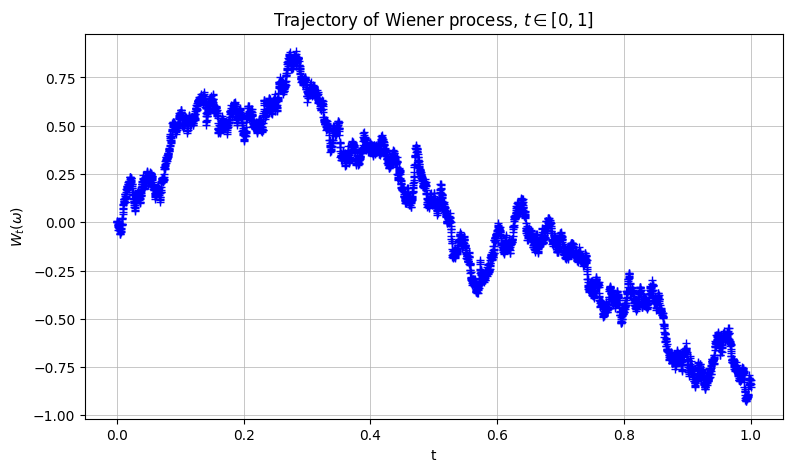

In [50]:
grid = np.linspace(0, 1, 2**depth + 1, endpoint=True)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

plt.plot(grid, wiener_trajectory, 'b+')

plt.title('Trajectory of Wiener process, $t\in[0,1]$')
plt.ylabel('$W_t(\omega)$')
plt.xlabel('t')

plt.savefig('./images/wiener-trajectory.eps', format='eps')

### Решение для процесса Орнштейна-Уленбека

Стационарность процесса Орнштейна-Уленбека влечёт
$$
R_X(s,t) = R_X(|s-t|),\forall s,t;\qquad \mathbb{E}X_t \equiv \mu;\qquad \mathbb{D}X_t \equiv \sigma^2.
$$
Следовательно, для корреляционной функции также выполнено $\widetilde{R}_X(s,t)=R_X(|s-t|)$.

Марковость процесса Орнштейна-Уленбека влечёт
$$
\widetilde{R}_X(s,t) = \widetilde{R}_X(s,\tau)\cdot \widetilde{R}_X(\tau,t),\quad\forall s<\tau<t.
$$
Значит, из марковости и стационарности:
$$
\widetilde{R}_X(|s-t|) = \widetilde{R}_X(|s-\tau|)\cdot \widetilde{R}_X(|\tau - t|), \quad\forall s<\tau<t.
$$


Обозначим $x=s-\tau, y=\tau-t$. Тогда
$$
\widetilde{R}_X(|x+y|) = \widetilde{R}_X(|x|)\cdot \widetilde{R}_X(|y|),
$$
т.е. корреляционная функция удовлетворяет функциональному уравнению Коши. Возможны два случая.

1. $\widetilde{R}_X(t)\equiv 0,~\forall t>0$.
2. $\widetilde{R}_X(t)\equiv e^{-\theta t}, \theta>0$.

Далее считаем, что корреляцияционная функция ненулевая (иначе моделирование сводится к моделированию независимых нормально распределенных случайных величин со средним $\mu$ и дисперсией $\sigma^2$).

Тогда ковариационная функция имеет вид
$$
R_X(t_1,t_2)=\sigma^2e^{-\theta|t_2-t_1|},\quad \theta>0.
$$

Таким образом, $X_t\sim\mathcal{N}(\mu,\sigma^2)$. \
Далее будем считать $\mu=0$ (этого легко можно добиться на практике, рассматривая процесс $X_t-\mu$).


В отличие от винеровского процесса, $X_0$ не является фиксированной величиной. \
Найдем распределение $Z = X_1|X_0$:
$$
p_Z(x; x_0) = \dfrac{p_{(X_0,X_1)}(x_0, x)}{p_{X_0}(x_0)}.
$$

В данном случае
$$
\begin{aligned}
p_{(X_0,X_1)}(x_0, x) &= \dfrac{1}{\sqrt{(2\pi)^2|\Sigma_{01}|}} \exp\left\{ -\dfrac{1}{2}(x_0, x)\Sigma_{01}^{-1}(x_0, x)^T \right\}. \\
\Sigma_{01} &= \{ R_X(i,j) \}_{i,j=0,1} = \sigma^2\begin{pmatrix}
1 & e^{-\theta} \\
e^{-\theta} & 1
\end{pmatrix}. \\
|\Sigma_{01}| &= \sigma^4(1-e^{-2\theta}). \\
\Sigma_{01}^{-1} &= \frac{\sigma^2}{\sigma^4(1-e^{-2\theta})}\begin{pmatrix}
1 & -e^{-\theta} \\
-e^{-\theta} & 1
\end{pmatrix}.
\end{aligned}
$$

Тогда
$$
\begin{aligned}
p_Z(x; x_0) &= \dfrac{1}{\sqrt{2\pi\sigma^2(1-e^{-2\theta})}}\exp\left\{
    -\dfrac{x_0^2 - 2x_0xe^{-\theta} + x^2}{2\sigma^2(1-e^{-2\theta})} + \dfrac{x_0^2}{2\sigma^2}
\right\} = \\
&= \dfrac{1}{\sqrt{2\pi\sigma^2(1-e^{-2\theta})}}\exp\left\{
    -\dfrac{(x-x_0e^{-\theta})^2}{2\sigma^2(1-e^{-2\theta})}
\right\}.
\end{aligned}
$$
Таким образом, $p_Z(x; x_0)\sim\mathcal{N}(x_0e^{-\theta},\sigma^2(1-e^{-2\theta}))$.

Аналогично прошлом пункту нас интересует распределение $Y = X_{t_3}|X_{t_1}=x_1,X_{t_2}=x_2$, где $t_3=\frac{t_1+t_2}{2}$.

Вычислим переходную плотность $p_Y(x;x_1,x_2) = p_Y(x ~|~ X_{t_1}=x_1, X_{t_2}=x_2)$:
$$
p_Y(x;x_1,x_2) = \dfrac{p_{(X_{t_1},X_{t_3},X_{t_2})}(x_1, x, x_2)}{p_{(X_{t_1},X_{t_2})}(x_1,x_2)}.
$$

Обозначим
$$
\begin{aligned}
\Sigma_{12} &= \{R_X(t_i,t_j) \}_{i,j=1,2} = \sigma^2\begin{pmatrix}
1 & e^{-\theta(t_2-t_1)} \\
e^{-\theta(t_2-t_1)} & 1
\end{pmatrix}, \\
\Sigma_{132} &= \sigma^2\begin{pmatrix}
1 & e^{-\theta(t_3-t_1)} & e^{-\theta(t_2-t_1)} \\
e^{-\theta(t_3-t_1)} & 1 & e^{-\theta(t_2-t_3)} \\
e^{-\theta(t_2-t_1)} & e^{-\theta(t_2-t_3)} & 1
\end{pmatrix}.
\end{aligned}
$$

Следовательно,
$$
p_{(X_{t_1},X_{t_3},X_{t_2})}(\omega_1,\omega,\omega_2) = \dfrac{1}{\sqrt{(2\pi)^3|\Sigma_{132}|}}
\exp\left\{ -\dfrac{1}{2} (x_1,x,x_2)\Sigma_{132}^{-1}(x_1,x,x_2)^T \right\}. \\
p_{(X_{t_1},X_{t_2})}(x_1,x_2) = \dfrac{1}{\sqrt{(2\pi)^2|\Sigma_{12}|}}
\exp\left\{ -\dfrac{1}{2}(x_1,x_2)\Sigma_{12}^{-1}(x_1,x_2)^T \right\}.
$$

In [26]:
x_1, x, x_2 = sym.symbols('x_1 x x_2', real=True)
h = sym.Symbol('h', real=True)
sigma = sym.symbols('sigma', real=True)
theta = sym.symbols('theta', real=True)
t_1, t_2, t_3 = sym.symbols('t_1 t_2 t_3', real=True)

t_3 = (t_1 + t_2) / 2

C12 = sigma ** 2 * sym.Matrix([
    [1, sym.exp(-theta * 2*h)],
    [sym.exp(-theta * 2*h), 1]
])
C132 = sigma ** 2 * sym.Matrix([
    [1, sym.exp(-theta * h), sym.exp(-theta * 2*h)],
    [sym.exp(-theta * h), 1, sym.exp(-theta * h)],
    [sym.exp(-theta * 2*h), sym.exp(-theta * h), 1]
])

vec_132 = sym.Matrix([x_1, x, x_2])
vec_12 = sym.Matrix([x_1, x_2])

In [27]:
new_sigma_2 = (C132.det() / C12.det()).simplify()
new_sigma_2

sigma**2*tanh(h*theta)

In [28]:
exp_factor = (-sym.Rational(1, 2) * vec_132.T @ C132.inv() @ vec_132)[0] + (sym.Rational(1, 2) * vec_12.T @ C12.inv() @ vec_12)[0]
exp_factor = exp_factor.simplify().factor()
exp_factor

-(x*exp(2*h*theta) + x - x_1*exp(h*theta) - x_2*exp(h*theta))**2/(2*sigma**2*(exp(h*theta) - 1)*(exp(h*theta) + 1)*(exp(2*h*theta) + 1))

Для удобства обозначим $h = t_3-t_1, 2h = t_2-t_1$ и
$$
\widetilde\sigma^2 = \dfrac{\sigma^2(e^{h\theta}-e^{-h\theta})}{e^{h\theta}+e^{-h\theta}} = \dfrac{\sigma^2(e^{2h\theta}-1)}{e^{2h\theta}+1}.
$$
Тогда
$$
-\dfrac{(x e^{2h\theta} + x - x_1e^{h\theta} - x_2e^{h\theta})^2}
{2\sigma^2(e^{h\theta}-1)(e^{h\theta}+1)(e^{2h\theta}+1)} = 
-\dfrac{(x - \frac{e^{h\theta}(x_1+x_2)}{e^{2h\theta}+1})^2}{2\widetilde\sigma^2}.
$$
Таким образом,
$$
p_Y(x;x_1,x_2) = \dfrac{1}{\sqrt{2\pi\widetilde\sigma^2}}\exp\left\{ -\dfrac{(x - \frac{e^{h\theta}(x_1+x_2)}{e^{2h\theta}+1})^2}{2\widetilde\sigma^2} \right\},
$$
т.е. $Y\sim\mathcal{N}\left( \dfrac{x_1+x_2}{e^{h\theta}+e^{-h\theta}}, \dfrac{\sigma^2(e^{h\theta}-e^{-h\theta})}{e^{h\theta}+e^{-h\theta}} \right)$.

In [29]:
def modelate_ornstein_uhlenbeck(depth=1, sigma=1.0, theta=1.0, x_0=0.0):
    """
    Modelate trajectory of Ornstein-Uhlenbeck process X_t(\omega),t\in[0,1]
    arguments:
        depth - depth of bisection
        sigma, theta - covariation parameteres
        x_0 - starting value
    returns vector of size 2^depth + 1
    """
    if not isinstance(depth, (int, np.integer)) or depth <= 0:
        raise ValueError('Depth must be a positive integer number.')
    if sigma <= 0:
        raise ValueError('Sigma must be a positive float number.')
    if theta < 0:
        raise ValueError('Theta must be a non-negative float number.')
    result = np.zeros(2 ** depth + 1)
    # modelate X_0 and X_1|X_0
    result[0] = x_0
    result[-1] = rand_norm(x_0 * np.exp(-theta), sigma * np.sqrt(1 - np.exp(-2*theta)))
    for k in range(1, depth+1):
        first = 2 ** (depth - k)            # first element to step from
        step = 2 ** (depth - k + 1)         # index step value
        h = 2 ** (-k)                       # t_2 - t_1
        for i in range(first, 2 ** depth + 1, step):
            x_1 = result[i - step//2]       # add a split at depth=k
            x_2 = result[i + step//2]
            loc = (x_1 + x_2) / (2 * np.cosh(h * theta))
            scale = sigma * np.sqrt(np.tanh(h * theta))
            result[i] = rand_norm(loc, scale)
    return result

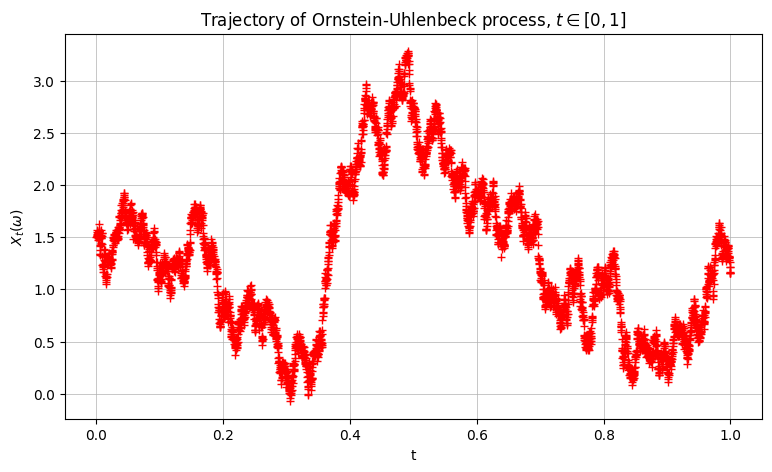

In [30]:
# modelate the process
depth = 12
sigma = 2.25
theta = 0.75
x_0 = 1.5
ornstein_uhlenbeck_trajectory = modelate_ornstein_uhlenbeck(depth, sigma, theta, x_0)

# plotting
grid = np.linspace(0, 1, 2**depth + 1, endpoint=True)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

plt.plot(grid, ornstein_uhlenbeck_trajectory, 'r+')

plt.title('Trajectory of Ornstein-Uhlenbeck process, $t\in[0,1]$')
plt.ylabel('$X_t(\omega)$')
plt.xlabel('t')

plt.savefig('./images/ornstein-uhlenbeck-trajectory.eps', format='eps')

## Задание 10

### Условие

Произвести фильтрацию одномерного процесса Орнштейна-Уленбека:

1. Используя генератор белого шума, добавить к реализации процесса Орнштейна-Уленбека случайную ошибку с заранее известной дисперсией.

2. При помощи одномерного фильтра Калмана оценить траекторию процесса по зашумленному сигналу, считая известными параметры шума и процесса.

3. Рассмотреть следующие виды шума:
    1. Гауссов
    2. Коши (шум имеет распределение Коши)

### Теоретические выкладки

Рассмотрим дискретный одномерный фильтр Калмана для динамической системы вида:
$$
\begin{cases}
x_{n+1} = ax_n + \nu_n, \\
y_n = x_n + \varepsilon_n, \\
x_1 \sim \mathcal{N}(0,\sigma^2),
\end{cases}
$$
где 
- $\nu_n\sim\mathcal{N}(0,q)$ - н.о.р.с.в.; 
- $\varepsilon_n$ - шум, распределен как $\mathcal{N}(0,r)$ или $\mathcal{C}(0,r)$; 
- $r,\sigma^2 > 0$ - заданные параметры;
- $a,q$ - неизвестные величины.

Для определения коэффициентов уравнения динамики необходимо приравнять теоретические значения ковариационной матрицы процесса Орнштейна-Уленбека в
точках $t_n$ и $t_{n+1}$ c соответствующими значениями динамической системы, то есть решить систему уравнений относительно неизвестных коэффициентов $a$ и $q$ через известные $\sigma$ и $\theta$:
$$
\begin{cases}
R_X(t_n,t_n) = \sigma^2 = \mathbb{D}x_n, \\
R_X(t_n,t_{n+1}) = \sigma^2 e^{-\theta(t_{n+1}-t_n)} = \operatorname{cov}(x_n,x_{n+1}) = a\mathbb{D}x_n, \\
R_X(t_{n+1},t_{n+1}) = \sigma^2 = \mathbb{D}x_{n+1} = a^2 \mathbb{D}x_n + q.
\end{cases}
$$

Положим, что наблюдение происходит на равномерной сетке отрезка $[0,1]$ с шагом $h$. Тогда решением указанной системы является
$$
a = e^{-\theta h},\quad q = \sigma^2(1 - e^{-2\theta h}).
$$

При помощи фильтра Калмана будем оценивать траекторию зашумленного процесса $y_n$: построим доверительный интервал $[\hat x_n-k_\alpha R_n,\hat x_n-k_\alpha R_n]$

При фильтрации значение оригинального процесса (сигнала) $x_n$ неизвестно. Вместо него доступен наблюдаемый зашумленный сигнал $y_n$.

Выведем итеративный алгоритм, который позволит по значениям зашумленного сигнала $y_n = x_n + \varepsilon_n$ оптимальным образом найти истинное значение сигнала $x_n$.

Обозначим
- оценка $x_n$ на $n$-ом шаге $x_n^{\operatorname{opt}}$
- величина ошибки на $n$-ом шаге $e_n = x_n - x_n^{\operatorname{opt}}$
- коэффициент Калмана $K_{n}$

Будем искать оптимальное значение как линейную комбинацию зашумленного сигнала и предсказанного значения на прошлом шаге:
$$
x_{n+1}^{\operatorname{opt}} = K_{n+1}y_{n+1} + M_{n+1}x_n^{\operatorname{opt}},\quad x_1^{\operatorname{opt}} = x_1\sim\mathcal{N}(0,\sigma^2).
$$

Выведем реккурентные соотношения для значения ошибки:
$$
\begin{aligned}
e_{n+1} &= x_{n+1} - K_{n+1}y_{n+1} - M_{n+1}x_n^{\operatorname{opt}} = \\
&= ax_n + \nu_n - K_{n+1}(ax_n + \nu_n + \varepsilon_{n+1}) - M_{n+1}x_n^{\operatorname{opt}} = \\
&= (1 - K_{n+1})(ax_n + \nu_n) - K_{n+1}\varepsilon_{n+1} - M_{n+1}x_n^{\operatorname{opt}} = \\
&= (1 - K_{n+1})(a(x_n-x_n^{\operatorname{opt}}) + ax_n^{\operatorname{opt}} + \nu_n) - K_{n+1}\varepsilon_{n+1} - M_{n+1}x_n^{\operatorname{opt}} = \\
&= (1 - K_{n+1})(ae_n + \nu_n) - K_{n+1}\varepsilon_{n+1} - (M_{n+1} - a(1 - K_{n+1}))x_n^{\operatorname{opt}}.
\end{aligned}
$$
Положим $M_n = a(1 - K_n)$. Тогда
$$
x_{n+1}^{\operatorname{opt}} = K_{n+1}y_{n+1} + a(1 - K_{n+1})x_n^{\operatorname{opt}}.
$$
$$
e_{n+1} = (1 - K_{n+1})(ae_n + \nu_n) - K_{n+1}\varepsilon_{n+1}.
$$

Если применить оператор математического ожидания к правой части схемы для $e_{n+1}$, то, полагая $\mathbb{E}e_1 = 0$, получим $\mathbb{E}e_{n+1}=0$.

На каждом шаге минимизируем дисперсию ошибки:
$$
\mathbb{E}e^2_n\to\min
$$
Из этих соображений выводим реккурентные соотношения для коэффициента Калмана.
$$
\begin{aligned}
\mathbb{E}e_{n+1}^2 &= a^2(1-K_{n+1})^2(\mathbb{E}e_n^2 + q) + K^2_{n+1}r.\quad\bigg|\quad\cdot\frac{\partial}{\partial K_{n+1}} \\
0 &= 2a^2(K_{n+1}-1)(\mathbb{E}e_n^2 + q) + 2K_{n+1}r. \\
K_{n+1} &= \dfrac{a^2(\mathbb{E}e_n^2 + q)}{a^2(\mathbb{E}e_n^2 + q) + r}.
\end{aligned}
$$

Итоговая схема имеет вид
$$
\begin{cases}
% x_{n+1} = e^{-\theta h}x_n + \nu_n, \\
% y_{n} = x_n + \varepsilon_n, \\
K_{n+1} = \dfrac{a^2(\mathbb{E}e_n^2 + q)}{a^2(\mathbb{E}e_n^2 + q) + r}, \\
x^{\operatorname{opt}}_{n+1} = K_{n+1}y_{n+1} + a(1 - K_{n+1})x_n^{\operatorname{opt}}, \\
% e_n = x_n - x_n^{\operatorname{opt}}, \\
\mathbb{E}e_{n+1}^2 = a^2(1-K_{n+1})^2(\mathbb{E}e_n^2 + q) + K^2_{n+1}r, \\
x^{\operatorname{opt}}_1 = y_1,~ \mathbb{E}e_1^2 = r.
\end{cases}
$$

Доверительный интервал уровня значимости $\alpha$ для $x_n$ определим как 
$\left[x^{\operatorname{opt}}_n - k_{(1-\alpha)/2}\sqrt{\mathbb Ee_n^2}, x^{\operatorname{opt}}_n + k_{(1-\alpha)/2}\sqrt{\mathbb Ee_n^2}\right]$,
где $k_{(1-\alpha)/2}$ - квантиль уровня значимости $(1-\alpha)/2$ стандартного нормального распределения.

Действительно, значения $x_n - x_n^{\operatorname{opt}} = e_n$ имеют дисперсию $\mathbb Ee_n^2$ и при предположении, что ошибка распределена нормально
$$
\begin{aligned}
\mathbb P(- k_{(1-\alpha)/2}\sqrt{\mathbb Ee_n^2} \leqslant e_n \leqslant k_{(1-\alpha)/2}\sqrt{\mathbb Ee_n^2}) &= 
\left\{ \xi \sim \mathcal{N}(0,1)\right\} = \\
&= P(- k_{(1-\alpha)/2} \leqslant \xi \leqslant k_{(1-\alpha)/2}) = \\
&= 2\Phi(k_{(1-\alpha)/2}) - 1 = \\
&= \alpha.
\end{aligned}
$$
Для данного процесса $x_n$ имеет нормальное распределение, ошибка распределена нормально.
<!-- При рассмотрении зашумленного распределением Коши процесса, вообще говоря, это неверно. -->

In [31]:
def filter_ornstein_uhlenbeck(trajectory, theta, sigma, r):
    """
    Kalman's filter for Ornstein-Uhlenbeck dynamics
    """
    n_points = len(trajectory)      # grid point count
    err2_n = np.zeros(n_points)     # variation of error
    xopt_n = np.zeros(n_points)     # predicted values
    xopt_n[0] = trajectory[0]       # starting from noisy data
    err2_n[0] = r                   # noise at 0 has variation = r
    h = 1 / (n_points-1)            # grid step size

    a = np.exp(-theta * h)          # discrete scheme paramateres
    a2 = np.exp(-2 * theta * h)
    q = sigma**2 * (1 - a2)
    for i in range(1, n_points):
        K = a2 * err2_n[i-1] / (a2 * (err2_n[i-1] + q) + r)             # Kalman's coefficient
        xopt_n[i] = K * trajectory[i] + a * (1 - K) * xopt_n[i-1]       # predict
        err2_n[i] = a2 * (1 - K)**2 * (err2_n[i-1] + q) + K**2 * r      # calculate error
    return xopt_n, err2_n

### Решение для гауссова шума

In [32]:
# modelate the process
depth = 12
sigma = 2.25
theta = 0.75
x_0 = 1.5
ornstein_uhlenbeck_trajectory = modelate_ornstein_uhlenbeck(depth, sigma, theta, x_0)

# put some noise
r = 1.25
noisy_trajectory = ornstein_uhlenbeck_trajectory + rand_norm(0, np.sqrt(r), 2**depth + 1)

# filter the process
filtered_trajectory, mean_err2 = filter_ornstein_uhlenbeck(
    noisy_trajectory,
    theta, 
    sigma,
    r
)

# calculate confidence interval
alpha = 0.99
k_alpha = norm.ppf((1-alpha)/2)
lower_bound = filtered_trajectory - k_alpha * np.sqrt(mean_err2)
upper_bound = filtered_trajectory + k_alpha * np.sqrt(mean_err2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


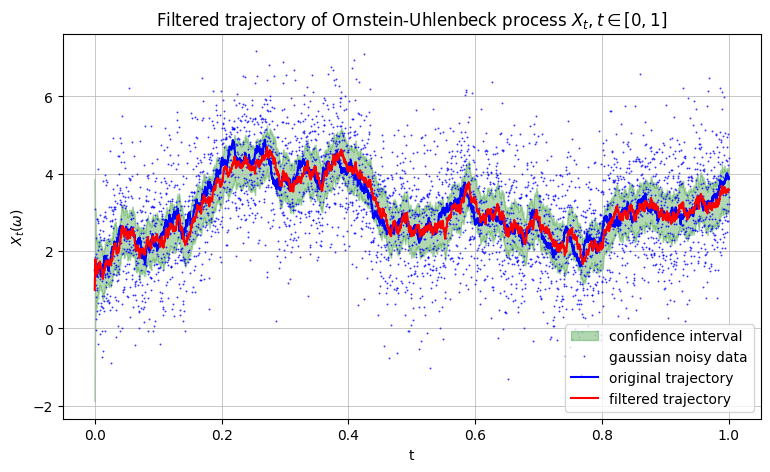

In [33]:
grid = np.linspace(0, 1, 2**depth + 1, endpoint=True)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.fill_between(grid, lower_bound, upper_bound, color='g', alpha=0.3, label='confidence interval')
plt.plot(grid, noisy_trajectory, '*b', alpha=0.7, ms=0.8, label='gaussian noisy data')
plt.plot(grid, ornstein_uhlenbeck_trajectory, 'b', label='original trajectory')
plt.plot(grid, filtered_trajectory, 'r', label='filtered trajectory')

plt.title('Filtered trajectory of Ornstein-Uhlenbeck process $X_t,t\in[0,1]$')
plt.ylabel('$X_t(\omega)$')
plt.xlabel('t')
plt.legend()

plt.savefig('./images/kalman-gaussian.eps', format='eps')

### Решение для шума с распределением Коши

In [34]:
# modelate the process
depth = 12
sigma = 2.25
theta = 0.75
x_0 = 1.5
ornstein_uhlenbeck_trajectory = modelate_ornstein_uhlenbeck(depth, sigma, theta, x_0)

# put some noise
r = 1.25
noisy_trajectory = ornstein_uhlenbeck_trajectory + rand_Cauchy(0, np.sqrt(r), 2**depth + 1)

# cut off values that are too big or too small
upp = np.percentile(noisy_trajectory, 95)
low = np.percentile(noisy_trajectory, 5)
indic1 = (noisy_trajectory >= low)
indic2 = (noisy_trajectory <= upp)
indic = indic1 & indic2
ornstein_uhlenbeck_trajectory = ornstein_uhlenbeck_trajectory[indic]
noisy_trajectory = noisy_trajectory[indic]

# filter the process
filtered_trajectory, mean_err2 = filter_ornstein_uhlenbeck(
    noisy_trajectory,
    theta, 
    sigma,
    r
)

# calculate confidence interval
alpha = 0.99
k_alpha = norm.ppf((1-alpha)/2)
lower_bound = filtered_trajectory - k_alpha * np.sqrt(mean_err2)
upper_bound = filtered_trajectory + k_alpha * np.sqrt(mean_err2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


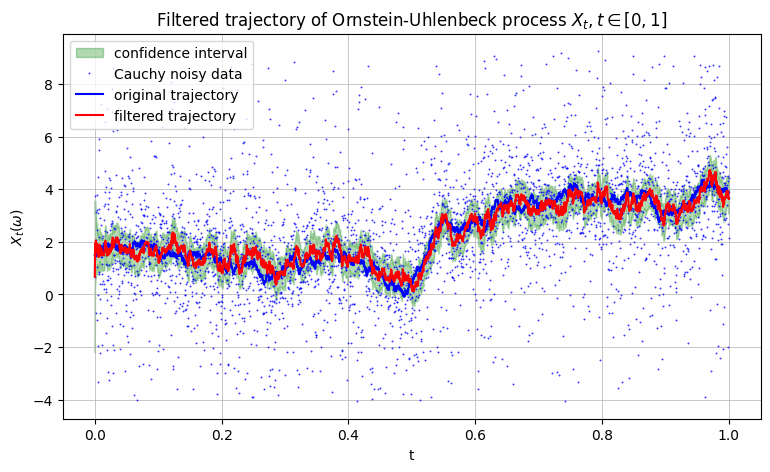

In [35]:
grid = np.linspace(0, 1, 2**depth + 1, endpoint=True)
grid = grid[indic]

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.fill_between(grid, lower_bound, upper_bound, color='g', alpha=0.3, label='confidence interval')
plt.plot(grid, noisy_trajectory, '*b', alpha=0.7, ms=0.8, label='Cauchy noisy data')
plt.plot(grid, ornstein_uhlenbeck_trajectory, 'b', label='original trajectory')
plt.plot(grid, filtered_trajectory, 'r', label='filtered trajectory')

plt.title('Filtered trajectory of Ornstein-Uhlenbeck process $X_t,t\in[0,1]$')
plt.ylabel('$X_t(\omega)$')
plt.xlabel('t')
plt.legend()

plt.savefig('./images/kalman-cauchy.eps', format='eps')

## Задание 11

### Условие

Построить двумерное пуассоновское поле, отвечающее сложному пуассоновскому процессу:

1. Система массового обслуживания. Первая координата поля - время поступления заявки в СМО (распределение равномерно), а вторая - время обслуживания заявки (распределение $\chi^2$ с десятью степенями свободы).

2. Система массового обслуживания с циклической интенсивностью $\lambda(1+\cos(t))$ и единичными скачками. При помощи метода Льюиса и Шедлеара, свести задачу моделирования неоднородного пуассоновского процесса к моделированию двумерного пуассоновского поля, где первая координата распределена равномерно, а вторая имеет распределение Бернулли.

3. Работа страховой компании: первая координата - момент наступления страхового случая (равномерное распределение), вторая величина ущерба (распределение Парето). Поступление капитала считать линейным по времени со скоростью $c>0$, начальный капитал $W>0$.

### Система массового обслуживания (СМО)

Рассмотрим двумерное пуассоновское поле $(t,s)$, где
- координата $t$ отвечает времени поступления заявки;
- координата $s$ отвечает времени обслуживания заявки.

Обозначим
- время $T$ - конечное время работы системы;
- интенсивность $\lambda > 0$ - среднее число поступающих заявок в единицу времени.

Рассмотрим модель, в которой
- времена поступлений заявок $t \sim \mathcal{U}[0,T]$;
- число заявок $n$ имеет распределение Пуассона: $n\sim\mathrm{Pois}(\lambda T)$;
- время обработки $k$-ой заявки $s_k\sim\chi^2_{m},m=10$.

Нас интересует число заявок $N(t)$, стоящих в очереди на обработку, в заданный момент времени $t\in[0,T]$.

Положим, что времена поступления заявок упорядочены: $0\leqslant t_1\leqslant t_2\leqslant \dots\leqslant t_n$.

Определим $X_k$ как время окончания обработки $k$-ой заявки. Нетрудно заметить, что
$$
\begin{aligned}
X_1 &= t_1 + s_1. \\
X_k &= \begin{cases}\begin{array}{cc}
t_k + s_k, & X_{k-1} \leqslant t_{k}, \\
X_{k-1} + s_k, & X_{k-1} > t_{k}.
\end{array}\end{cases}
\end{aligned}
$$

Событие $\{X_k > t \geqslant t_k\}$ возможно (имеет положительную вероятность), если $k$-ая заявка поступила в обработку ($t \geqslant t_k$), но к текущему моменту времени $t$ не была до конца обработана ($X_k > t$).

Таким образом,
$$
N(t) = \sum_{k=1}^n \mathbb{I}\{ X_k > t \geqslant t_k \},
$$
где $\mathbb{I}\{\cdot\}$ - индикатор некоторого события.

Отметим, что
$$
t_{k+1}-t_k\sim\mathrm{Exp}(\lambda),\quad k=\overline{1,n-1}
$$
Тогда среднее время ожидания между заявками
$$
\mathbb{E}[t_{k+1}-t_k] = \frac{1}{\lambda}.
$$
Однако первый момент распределения $\chi^2_m$ равняется
$$
\mathbb{E}s_k = m = 10.
$$

Следовательно, поведение $N(t)$ можно описать в рамках средних значений:
- если $\lambda > 0.1$, то среднее время ожидания меньше среднего времени обработки заявки, система перегружается;
- если $\lambda = 0$, то про поведение системы в среднем ничего нельзя сказать;
- если $\lambda < 0.1$, то среднее время ожидания больше среднего времени обработки заявки, система не перегружается.

Моделируем работу системы массового обслуживания согласно следующему алгоритму:
1. $n\sim\mathrm{Pois}(\lambda T)$;
2. $t_k\sim\mathrm{U}[0,T],~ t_1\leqslant t_2\leqslant \dots \leqslant t_n,~ k=\overline{1,n}$;
3. $s_k\sim\chi^2_{10},~ k=\overline{1,n}$;
4. Вычисляем $X_k$;
5. Задаём сетку по времени и вычисляем $N(t)$.

In [36]:
def rand_chi2(m, *args):
    """
    Chi-squared distribution with m degrees of freedom.
    """
    return (rand_norm(0, 1, m, *args) ** 2).sum(axis=0)

In [37]:
m = 10
n_points = 10**6
chi2_sample = rand_chi2(m, n_points)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


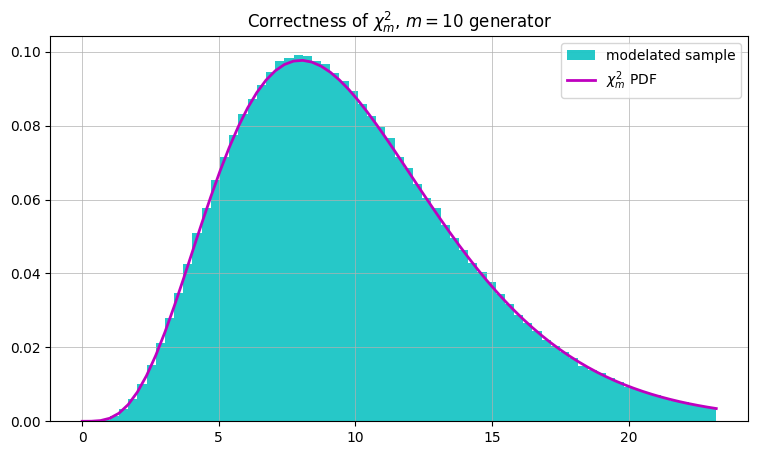

In [38]:
n_bins = 70
percentile = chi2.ppf(0.99, m)
bins = np.linspace(0, percentile, n_bins, endpoint=True)

plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

plt.hist(chi2_sample, bins=bins, density=True, color='c', alpha=0.85, label='modelated sample')
plt.plot(bins, chi2.pdf(bins, m), color='m', label='$\chi^2_m$ PDF', linewidth=2)

plt.title(f'Correctness of $\chi^2_m$, $m={m}$ generator')
plt.legend()

plt.savefig('./images/chi-square.eps', format='eps')

In [39]:
def modelate_queue(T, l, n_points):
    """
    Modelate queuing system (t,s), where time t is uniformly distributed
    and s is chi-squared with 10 degrees of freedom distributed.
    Args:
        T - time period
        l - intensity per unit of time
        n_points - number of points in resulting grid [0,T]
    Returns:
        grid  - times of observation
        queue - number of messages at grid
        times - times of messages arriving
    """
    n = rand_poisson_expo_vec(l * T)
    if n == 0:
        return [], [], []
    times = np.sort(np.random.rand(n)) * T
    msgs = rand_chi2(10, n)
    X = np.zeros(n)
    X[0] = times[0] + msgs[0]
    for i in range(1, n):
        X[i] = max(times[i], X[i-1]) + msgs[i]

    grid = np.linspace(0, T, n_points, endpoint=True)
    queue = np.zeros(n_points)
    for i in range(n_points):
        queue[i] = ((grid[i] >= times) & (X > grid[i])).astype(int).sum()

    return grid, queue, times

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


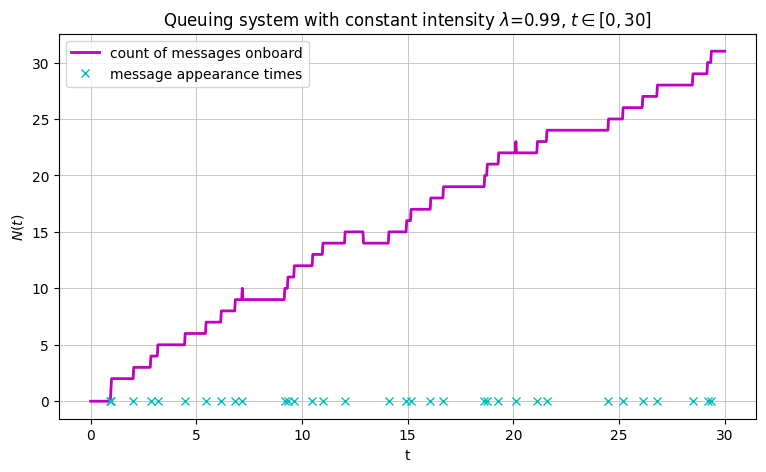

In [40]:
T = 30
n_points = 1000
l = 0.99

grid, queue, times = modelate_queue(T, l, n_points)

plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

plt.plot(grid, queue, linewidth=2, label='count of messages onboard', color='m')
plt.plot(times, np.zeros(times.shape), 'xc', label='message appearance times')

plt.title(f'Queuing system with constant intensity $\lambda$={l}, $t\in[0,{T}]$')
plt.ylabel('$N(t)$')
plt.xlabel('t')
plt.legend()

plt.savefig('./images/qs-constant.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


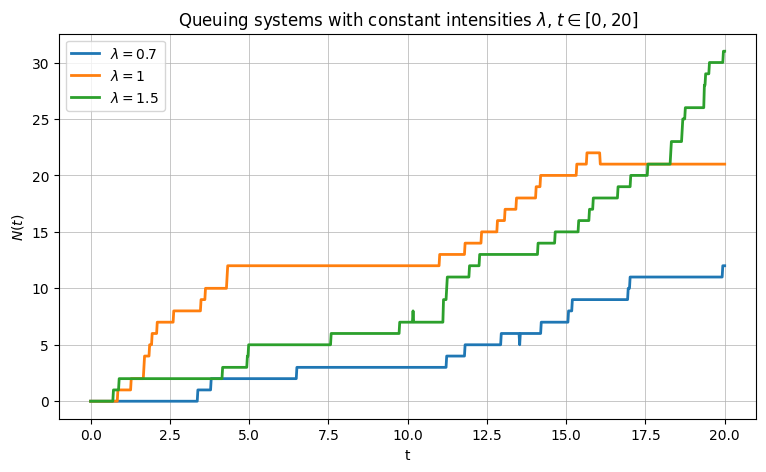

In [41]:
T = 20
n_points = 1000
lambdas = [0.7, 1, 1.5]

plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

for l in lambdas:
    grid, queue, _ = modelate_queue(T, l, n_points)
    plt.plot(grid, queue, linewidth=2, label=f"$\lambda={l}$")

plt.title(f'Queuing systems with constant intensities $\lambda$, $t\in[0,{T}]$')
plt.ylabel('$N(t)$')
plt.xlabel('t')
plt.legend()

plt.savefig('./images/qs-multiple-constant.eps', format='eps')

### СМО с циклической интенсивностью

Моделирование неоднородного пуассоновского процесса с интенсивностью $\lambda(x)$ на фиксированном интервале может быть основано на прореживании неоднородного пуассоновского процесса с интенсивностью $\lambda^*(x)\geqslant\lambda(x)$.

__Теорема__ Рассмотрим неоднородный пуассоновский процесс $\{N^*(x):~x\geqslant0 \}$ с интенсивностью $\lambda^*(x)$. Пусть $N^*(x_0)$ - количество точек на фиксированном полуинтервале $(0,x_0]$ и $N^*(x_0)\sim\mathrm{Pois}(\mu^*_0)$, где $\mu^*_0=\Lambda^*(x_0) - \Lambda^*(0)$. Пусть $X_1^*,X_2^*,\dots,X^*_{N^*(x_0)}$ - точки на $(0,x_0]$ и, к тому же, $\lambda(x)\leqslant\lambda^*(x),0\leqslant x\leqslant x_0$  Тогда при удалении на $i$-ом шаге ($i\in\{1,2,\dots,n\}$) точки $X^*_i$ с вероятностью $1-\frac{\lambda(X_i^*)}{\lambda^*(X_i^*)}$ оставшиеся точки образуют неоднородный пуассоновский процесс с интенсивностью $\lambda(x)$ на полуинтервале $(0,x_0]$.

Доказательство приведено в [6].

Опишем метод Льюиса и Шедлеара моделирования одномерного неоднородного пуассоновского процесса. Будем моделировать точки $X_1,X_2,\dots,X_n$ исходного процесса $\{N(x):x\geqslant0\}$.

1. Смоделировать точки неоднородного пуассоновского процесса $\{N^*(x): x\geqslant0\}$ с функцией интенсивности $\lambda^*(x)$ на фиксированном интервале $(0,x_0]$. Если число сгенерированных точек $n^*$ равно нулю, то стоп (точек второго процесса $\{N(x):x\geqslant0\}$ нет).
2. Полученные точки $X_1^*,X_2^*,\dots,X_n^*$ упорядочить. Положим $i=1,k=0$.
3. Смоделировать $U_i\sim\mathrm{U}[0,1]$. Если $U_i\leqslant\frac{\lambda(X_i^*)}{\lambda^*(X_i^*)}$, то $k:=k+1$ и $X_k = X^*_k$.
4. Присвоить $i:=i+1$. Если $i\leqslant n^*$, то повторяем шаг 3.
5. Вернуть $X_1,X_2,\dots,X_n$, где $n=k$.

Подробные сведения изложены в [6].

Рассмотрим СМО с циклической интенсивностью $\lambda(1+\cos t)$ и единичными скачками.

Положим $\lambda^*(t) = 2\lambda \geqslant \lambda(1+\cos t),~ \forall t\geqslant0$.

Тогда пуассоновский процесс $N^*(t)$ будем моделировать как в прошлом пункте, а затем применять к нему алгоритм прореживания.

Отметим, что в алгоритме
$$
\frac{\lambda(t_i)}{\lambda^*(t_i)} = \frac{\lambda(1+\cos t_i)}{2\lambda} = \frac{1 + \cos t_i}{2} =: p_i
$$
и сравнение $p_i \leqslant U_i$ равносильно моделированию $\mathrm{Be}(p_i)$.

In [42]:
def modelate_cyclic_queue(T, l, n_points):
    """
    Modelate cyclic queuing system (t,s), where time t is uniformly distributed
    and s is Bernoulli distributed.
    Args:
        T - time period
        l - intensity per unit of time
        n_points - number of points in resulting grid [0,T]
    Returns:
        grid  - times of observation
        queue - jumps at grid
        times - times of messages arriving
    """

    # modelate points of N^*(t)
    l_major = 2 * l
    n = rand_poisson_expo_vec(l_major * T)
    if n == 0:
        return [], [], []
    times = np.sort(np.random.rand(n)) * T

    # apply thinning algorithm
    jumps = np.ones(times.shape[0])
    for i in range(n):
        p_i = (1 + np.cos(times[i])) / 2
        if rand_bern(p_i) == 1:
            jumps[i] = 0       # remove point
    times = times[jumps == 1]

    # calculate queue on grid
    grid = np.linspace(0, T, n_points, endpoint=True)
    queue = np.zeros(n_points)
    for i in range(n_points):
        queue[i] = (times <= grid[i]).astype(int).sum()
    return grid, queue, times

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


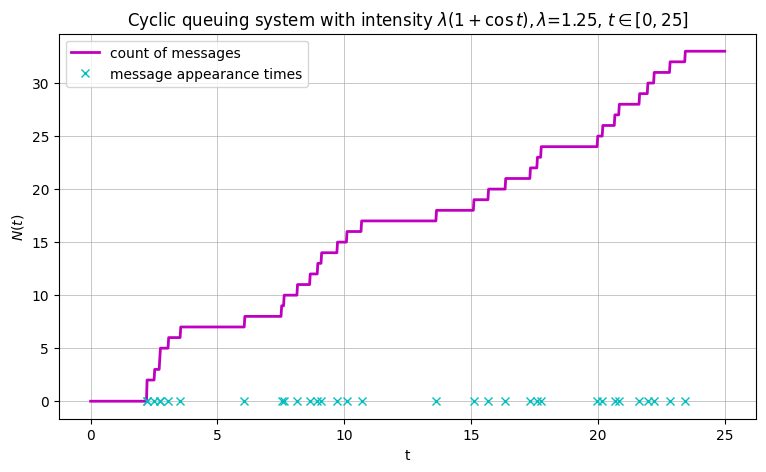

In [43]:
T = 25
n_points = 1000
l = 1.25

grid, queue, times = modelate_cyclic_queue(T, l, n_points)

plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

plt.plot(grid, queue, linewidth=2, label='count of messages', color='m')
plt.plot(times, np.zeros(times.shape), 'xc', label='message appearance times')

plt.title(f'Cyclic queuing system with intensity $\lambda(1+\cos t), \lambda$={l}, $t\in[0,{T}]$')
plt.ylabel('$N(t)$')
plt.xlabel('t')
plt.legend()

plt.savefig('./images/qs-cyclic.eps', format='eps')

### Моделирование страховой компании

Распределение Парето $P(k,\sigma)$ задаётся плотностью
$$
p_P(x) = \begin{cases}
\dfrac{k\sigma^k}{x^{k+1}}, & x\geqslant \sigma, \\
0, & x < \sigma,
\end{cases}
$$
где $k,\sigma > 0$ и $\sigma$ - коэффициент масштаба. Тогда функция распределения
$$
F_P(x) =\begin{cases}
1 - \left(\dfrac{\sigma}{x}\right)^k, & x\geqslant \sigma, \\
0, & x < \sigma.
\end{cases}
$$
Его математическое ожидание равняется $\frac{k\sigma}{k-1}$ при $k > 1$. \
При $k \leqslant 1$ его не существует.

Функция распределения Парето обратима:
$$
F^{-1}_P(y) = \sigma(1-y)^{-\frac{1}{k}},\quad y\in[0,1].
$$
Будем моделировать распределение Парето методом обращения функции распределения.

Обозначим $W(t)$ - капитал страховой компании к моменту времени $t\in[0,T]$.

Пусть число страховых случаев к моменту $t$ равняется $N(t)$ - однородный пуассоновский процесс с интенсивностью $\lambda$.

Положим $\kappa_i$ - величина страхового случая, который нужно выплатить в момент времени $t_i$.

Тогда по условию задачи $\kappa_i\sim P(k,\sigma)$ и 
$$
\begin{aligned}
\kappa_i &= \sigma(1 - U_i)^{-\frac{1}{k}},\quad U_i\sim\mathcal{U}[0,1], \\
W(t) &= W + ct - \sum^{N(t)}_{i=1}\kappa_i,
\end{aligned}
$$
где $W>0$ - начальный капитал, $c>0$ - скорость линейного роста капитала компании.

Алгоритм моделирования аналогичен задаче СМО с постоянной интенсивностью. \
Дополнительно учтём, что капитал страховой компании не может быть отрицательным. \
Будем считать, что при банкротстве страховая компания прекращает свою деятельность (дальнейший капитал нулевой).

Исследуем поведение капитала при $k>1$:
$$
\mathbb{E}W(t) = W + ct - \lambda t \frac{k\sigma}{k-1}.
$$
Таким образом,
- при $c > \frac{k\sigma}{k-1}$ капитал в среднем растёт;
- при $c < \frac{k\sigma}{k-1}$ капитал в среднем убывает, что приводит к банкротству;
- при равенстве $c = \frac{k\sigma}{k-1}$ про поведение капитала в среднем ничего нельзя сказать.

Если же $k\in(0,1]$, то в среднем $\mathbb{E}W(t)$ равно минус бесконечности, что влечёт банкротство в некоторый момент времени.

In [44]:
def rand_Pareto(k, sigma, *args):
    """
    Pareto distribution generator.
    k,sigma > 0.
    """
    return sigma * (1 - np.random.rand(*args)) ** (-1 / k)

In [45]:
k = 2.5
sigma = 1
n_points = 10**6
pareto_sample = rand_Pareto(k, sigma, n_points)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


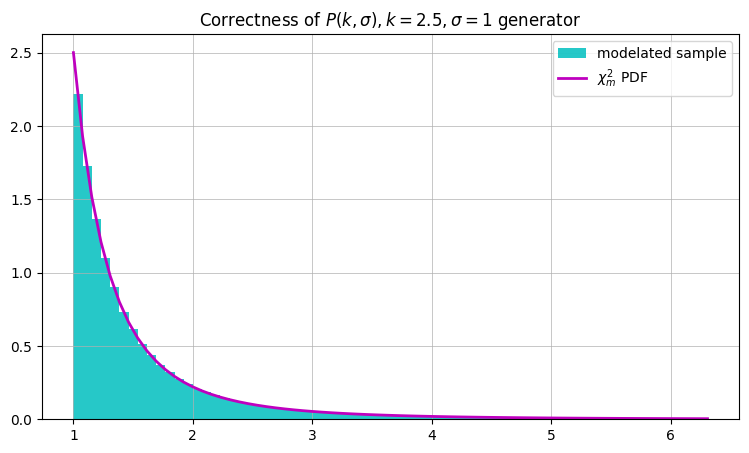

In [46]:
n_bins = 70
percentile = pareto.ppf(0.99, k)
bins = np.linspace(1, percentile, n_bins, endpoint=True)

plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

plt.hist(pareto_sample, bins=bins, density=True, color='c', alpha=0.85, label='modelated sample')
plt.plot(bins, pareto.pdf(bins, k), color='m', label='$\chi^2_m$ PDF', linewidth=2)

plt.title(f'Correctness of $P(k,\sigma),k={k},\sigma={sigma}$ generator')
plt.legend()

plt.savefig('./images/pareto.eps', format='eps')

In [47]:
def modelate_insurance_company(T, l, W, c, k, sigma, n_points):
    """
    Modelate capital of insurance company.
    Insurance payments are Pareto(k,sigma) random variables.
    Args:
        T - time period
        l - intensity per unit of time
        W - initial capital
        c - velocity of linear growth
        k, sigma - Pareto distribution parameters
        n_points - number of points in resulting grid [0,T]
    Returns:
        grid    - times of observation
        capital - capital at grid
        times   - times of payments arriving
        kappas  - payments at times vector
    """
    N = rand_poisson_expo_vec(l * T)
    if N == 0:
        return [], [], []
    times = np.sort(np.random.rand(N)) * T
    kappas = rand_Pareto(k, sigma, N)
    grid = np.linspace(0, T, n_points, endpoint=True)
    capital = np.zeros(n_points)
    for i in range(n_points):
        capital[i] = W + c * grid[i] - kappas[times <= grid[i]].sum()
        if capital[i] <= 0:
            capital[i] = 0
            times[times > grid[i]] = grid[i]
            break
    return grid, capital, times, kappas

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Bankruptcy condition: True


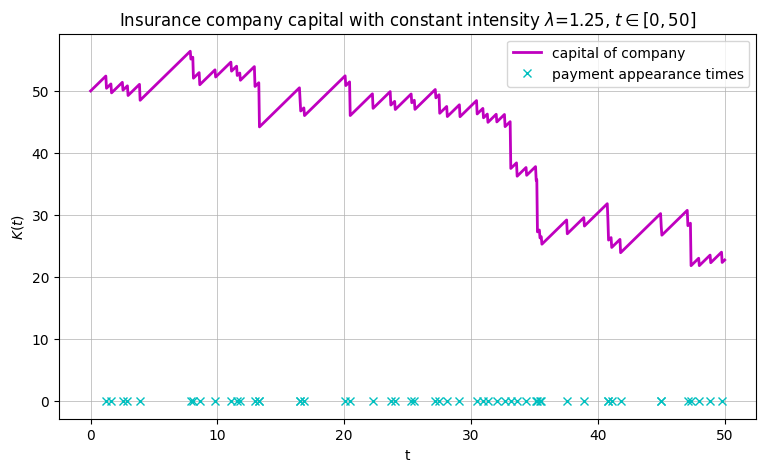

In [48]:
T = 50
l = 1.25
W = 50
c = 2
k = 2.5
sigma = 1.25
n_points = 1000

print(f"Bankruptcy condition: {(k < 1) or (k >= 1 and c < k*sigma/(k-1))}")

grid, capital, times, _ = modelate_insurance_company(T, l, W, c, k, sigma, n_points)

plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

plt.plot(grid, capital, linewidth=2, label='capital of company', color='m')
plt.plot(times, np.zeros(times.shape), 'xc', label='payment appearance times')

plt.title(f'Insurance company capital with constant intensity $\lambda$={l}, $t\in[0,{T}]$')
plt.ylabel('$K(t)$')
plt.xlabel('t')
plt.legend()

plt.savefig('./images/insurance-constant.eps', format='eps')

## Список литературы

[1]. Бусленко Н.П., Голенко Д.И., Соболь И.М., Срагович В.Г., Шрейдер Ю.А. Метод статистических испытаний. "Букинист", 1962.

[2] [Феллер В. Введение в теорию вероятностей и ее приложения, Том 1. М.: Мир, 1964.](https://ikfia.ysn.ru/wp-content/uploads/2018/01/Feller_t1_1964ru.pdf)

[3]. [Феллер В. Введение в теорию вероятностей и ее приложения, Том 2. М.: Мир, 1967.](https://ikfia.ysn.ru/wp-content/uploads/2018/01/Feller_t2_1967ru.pdf)

[4]. [Kalman R.E. A New Approach to Linear Filtering and Prediction Problems, Research Institute for Advanced Study, Baltimore, Md., 1960.](https://www.cs.unc.edu/~welch/kalman/media/pdf/Kalman1960.pdf)

[5]. Lewis P.A.W., Shedler G.S. Simulation of Nonhomogeneous Poisson Processses by Thinning, 1979.

[6]. Острем К.Ю. Введение в стохастическую теорию управления. "Мир", 1973.